In [50]:
%matplotlib inline

import sys, os, re, csv, codecs, numpy as np, pandas as pd
import matplotlib.pyplot as plt
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, Conv1D
from keras.layers import Bidirectional, GlobalMaxPooling1D, MaxPooling1D, SpatialDropout1D, BatchNormalization
from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers
from tqdm import tqdm
import gc

## Import Data

In [2]:
dtypes = {
    'comment_text': np.unicode,
    "toxic": np.float32,
    "severe_toxic": np.float32,
    "obscene": np.float32,
    "threat": np.float32,
    "insult": np.float32,
    "identity_hate": np.float32
}
train = pd.read_csv("data/train.csv", dtype=dtypes) #, encoding='utf-8'
test = pd.read_csv("data/test.csv", dtype=dtypes) # , encoding='utf-8'

train.comment_text.fillna("unknown", inplace=True)
test.comment_text.fillna("unknown", inplace=True)

In [3]:
classes = ["toxic", "severe_toxic", "obscene", "threat", "insult",
           "identity_hate"]
train_data = train['comment_text']  
labels = train[classes].values
list_sentences_train = train["comment_text"]
list_sentences_test = test["comment_text"]

 ## This is used to represent the corpus in the format of a  dictionary where every index represent a unique word and it is arranged from the most frequent to the least frequent

In [4]:
type(list(list_sentences_train)[1])

str

In [138]:
max_features = 20000 # Number of unique words in the corpus, needs optimization
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(list_sentences_train))
tokenized_train = tokenizer.texts_to_sequences(list_sentences_train)
tokenized_test = tokenizer.texts_to_sequences(list_sentences_test)

In [139]:
word_index = tokenizer.word_index
print('Found %d unique tokens.' % len(word_index))
word_count = tokenizer.word_counts
# print('Top 5 Frequent Words count. ' % word_count[5])

Found 153397 unique tokens.


In [140]:
print(tokenized_train[:1]) # Take a lot at the NN input

[[813, 4855, 200, 6773, 40, 7, 162, 8, 393, 234, 19, 20, 350, 14245]]


## This is done to normalize the length of the text sequences to the maxlen value

    This is called [Padding], it includes shortenning the long sentences and longing the short sentences by zeros so they equal the maxlen

In [141]:
maxlen = 200 # needs optimization
X = pad_sequences(tokenized_train, maxlen=maxlen)
X_t =pad_sequences(tokenized_test, maxlen=maxlen)

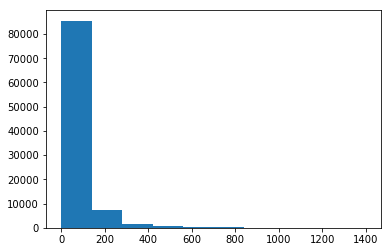

In [142]:
# Plot a histogram between the number of comments and the length of the comment
totalNumWords = [len(comment) for comment in tokenized_train]
plt.hist(totalNumWords) #, bins=np.range(0,500,10)
plt.show()

## Let's Start building the Model

<img src="images/txJomEa.png" >

In [143]:
# input is a list of encoded sentences, each sentence with a maxlen=200
input_layer = Input(shape=(maxlen, )) 

In [22]:
# Prepaing the Embedding Layer using Glove Word Vectors
embedding_index_glove = {}
f = open("../Sentiment_Model_Template/glove.840B.300d.txt")
for line in tqdm(f):
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embedding_index_glove[word] = coefs
f.close()
print('Found %s word vectors.' % len(embedding_index_glove))

2196017it [01:53, 19297.09it/s]

Found 2196016 word vectors.


In [42]:
def plot_loss_curve(history):
    """A function to plot losses and acuracies of a fitted
    keras model"""
    # summarize history for accuracy
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'valid'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'valid'], loc='upper left')
    plt.show()

In [23]:
gc.collect()

0

In [48]:
train_data.shape[0]

95851

In [145]:
# split the data into a training set and a validation set
VALIDATION_SPLIT = 0.2

indices = np.arange(X.shape[0])
np.random.shuffle(indices)
X = X[indices]
labels = labels[indices]
num_validation_samples = int(VALIDATION_SPLIT * X.shape[0])

x_train = X[:-num_validation_samples]
y_train = labels[:-num_validation_samples]
x_val = X[-num_validation_samples:]
y_val = labels[-num_validation_samples:]


In [146]:
labels.shape

(95851, 6)

In [147]:
print (x_train.shape)
print (x_val.shape)
print (y_train.shape)
print (y_val.shape)

(76681, 200)
(19170, 200)
(76681, 6)
(19170, 6)


In [148]:
# prepare embedding matrix
EMBEDDING_DIM = 300
num_words = min(max_features, len(word_index) + 1)
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word_index.items():
    if i >= max_features:
        continue
    embedding_vector = embedding_index_glove.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [149]:
MAX_SEQUENCE_LENGTH = maxlen
embedding_layer = Embedding(num_words,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)(input_layer)

# embedding_layer = Embedding(num_words,
#                             EMBEDDING_DIM,
#                             input_length=MAX_SEQUENCE_LENGTH,
#                             trainable=False)(input_layer)


In [150]:
x = LSTM(units=60, return_sequences=True, name='lstm_layer')(embedding_layer)

In [151]:
x = GlobalMaxPool1D()(x)

## This is done to achive Generalization, by doing some kind of regualization called [Droupout] 
    Which is basiclly done by droping the learned weights of a neuron in a NN to zero (dropout_ate=0.1) means that 10% of the neurons/nodes weights will be dropped to zero every iteration

In [152]:
x = Dropout(rate=0.1)(x)

## A densely connected layer anf the output passes through a ReLU functin

In [153]:
x = Dense(units=50, activation="relu")(x)

In [154]:
x = Dropout(rate=0.1)(x)

## Output layer has an activation [Sigmoid] to reduce the probabilities to a real number between [0, 1]

In [155]:
x = Dense(units=6, activation="sigmoid")(x) 

In [162]:
model = Model(inputs=input_layer, outputs=x)
model.compile(loss='binary_crossentropy',
              optimizer= 'adam',
              metrics= ['accuracy']) #{'toxic': 'accuracy', 'severe_toxic': 'accuracy', 'obscene': 'accuracy',
                        #'threat': 'accuracy', 'insult': 'accuracy', 'identity_hate': 'accuracy'}) # 'accuracy'

In [163]:
batch_size = 32
epochs = 10
model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_val, y_val))

Train on 76681 samples, validate on 19170 samples
Epoch 1/10
76681/76681 [==============================] - 358s - loss: 0.1426 - acc: 0.9634 - val_loss: 0.1447 - val_acc: 0.9621
Epoch 2/10
76681/76681 [==============================] - 356s - loss: 0.1422 - acc: 0.9634 - val_loss: 0.1450 - val_acc: 0.9621
Epoch 3/10
76681/76681 [==============================] - 362s - loss: 0.1418 - acc: 0.9634 - val_loss: 0.1450 - val_acc: 0.9621
Epoch 4/10
76681/76681 [==============================] - 379s - loss: 0.1408 - acc: 0.9634 - val_loss: 0.1456 - val_acc: 0.9621
Epoch 5/10
76681/76681 [==============================] - 376s - loss: 0.1404 - acc: 0.9634 - val_loss: 0.1463 - val_acc: 0.9621
Epoch 6/10
76681/76681 [==============================] - 352s - loss: 0.1405 - acc: 0.9634 - val_loss: 0.1486 - val_acc: 0.9621
Epoch 7/10
76681/76681 [==============================] - 349s - loss: 0.1395 - acc: 0.9634 - val_loss: 0.1463 - val_acc: 0.9621
Epoch 8/10
76681/76681 [=======================

In [164]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 200)               0         
_________________________________________________________________
embedding_7 (Embedding)      (None, 200, 300)          6000000   
_________________________________________________________________
lstm_layer (LSTM)            (None, 200, 60)           86640     
_________________________________________________________________
global_max_pooling1d_6 (Glob (None, 60)                0         
_________________________________________________________________
dropout_11 (Dropout)         (None, 60)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 50)                3050      
_________________________________________________________________
dropout_12 (Dropout)         (None, 50)                0         
__________

In [165]:
y_test = model.predict([X_t], batch_size=1024, verbose=1)

226998/226998 [==============================] - 205s   


In [166]:
sample_submission = pd.read_csv('data/sample_submission.csv')
sample_submission[classes] = y_test
sample_submission.to_csv('submissions/keras_lstm_submission.csv', index=False)


# A claimed improvement based on Jermey Howrad's [kernel](https://www.kaggle.com/jhoward/improved-lstm-baseline-glove-dropout)


In [167]:
all_embs = np.stack(embedding_index_glove.values())
emb_mean,emb_std = all_embs.mean(), all_embs.std()
emb_mean,emb_std

(-0.0058384896, 0.48782218)

In [168]:
# prepare embedding matrix
EMBEDDING_DIM = 300
num_words = min(max_features, len(word_index) + 1)
embedding_matrix_modified = np.random.normal(emb_mean, emb_std, (num_words, EMBEDDING_DIM))
for word, i in word_index.items():
    if i >= max_features:
        continue
    embedding_vector = embedding_index_glove.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix_modified[i] = embedding_vector

In [169]:
inp = Input(shape=(maxlen,))
x = Embedding(max_features, EMBEDDING_DIM, weights=[embedding_matrix_modified])(inp)
x = Bidirectional(LSTM(50, return_sequences=True, dropout=0.1, recurrent_dropout=0.1))(x)
x = GlobalMaxPool1D()(x)
x = Dense(50, activation="relu")(x)
x = Dropout(0.1)(x)
x = Dense(6, activation="sigmoid")(x)
model_mod = Model(inputs=inp, outputs=x)
model_mod.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [173]:
gc.collect()

0

In [174]:
batch_size = 32
epochs = 2
model_mod.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1, 
              validation_data=(x_val, y_val))

Train on 76681 samples, validate on 19170 samples
Epoch 1/2
76681/76681 [==============================] - 885s - loss: 0.1468 - acc: 0.9631 - val_loss: 0.1446 - val_acc: 0.9621
Epoch 2/2
76681/76681 [==============================] - 795s - loss: 0.1410 - acc: 0.9634 - val_loss: 0.1461 - val_acc: 0.9621


In [175]:
model_mod.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 200)               0         
_________________________________________________________________
embedding_8 (Embedding)      (None, 200, 300)          6000000   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 200, 100)          140400    
_________________________________________________________________
global_max_pooling1d_7 (Glob (None, 100)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 50)                5050      
_________________________________________________________________
dropout_13 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_14 (Dense)             (None, 6)                 306       
Total para

In [176]:
y_test_mod = model.predict([X_t], batch_size=1024, verbose=1)

226998/226998 [==============================] - 183s   


In [177]:
sample_submission = pd.read_csv('data/sample_submission.csv')
sample_submission[classes] = y_test_mod
sample_submission.to_csv('submissions/keras_lstm_mod_submission.csv', index=False)

# I will Try to improve the Keras Model by doing the following:
- Build Word embedding using the data training text data using [gensim](https://radimrehurek.com/gensim/models/word2vec.html) package

In [10]:
from nltk.tokenize import WordPunctTokenizer
from collections import Counter
from string import punctuation, ascii_lowercase
import regex as re

In [14]:
# replace urls
re_url = re.compile(r"((http|https)\:\/\/)?[a-zA-Z0-9\.\/\?\:@\-_=#]+\
                    .([a-zA-Z]){2,6}([a-zA-Z0-9\.\&\/\?\:@\-_=#])*",
                    re.MULTILINE|re.UNICODE)
# replace ips
re_ip = re.compile("\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}")

# setup tokenizer
tokenizer = WordPunctTokenizer()

vocab = Counter()

def text_to_wordlist(text, lower=False):
    # replace URLs
    text = re_url.sub("URL", text)
    
    # replace IPs
    text = re_ip.sub("IPADDRESS", text)
    
    # Tokenize
    text = tokenizer.tokenize(text)
    
    # optional: lower case
    if lower:
        text = [t.lower() for t in text]
    
    # Return a list of words
    vocab.update(text)
    return text

def process_comments(list_sentences, lower=False):
    comments = []
    for text in tqdm(list_sentences):
        txt = text_to_wordlist(text, lower=lower)
        comments.append(txt)
    return comments

list_sentences_train = list(train["comment_text"].fillna("unknown").values)
list_sentences_test = list(test["comment_text"].fillna("unknown").values)

comments = process_comments(list_sentences_train + list_sentences_test, lower=True)

100%|██████████| 322849/322849 [00:25<00:00, 12862.69it/s]


- Let's build a CBOW Word2Vec Model by specifing `sg=0` which means to deactivate SkipGram Model

In [15]:
from gensim.models import Word2Vec
model = Word2Vec(comments, size=100, window=5, min_count=5, workers=8, sg=0,
                 negative=5)

In [16]:
word_vectors =  model.wv
print("Number of word vectors: {}".format(len(word_vectors.vocab)))

Number of word vectors: 70910


In [17]:
model.wv.most_similar_cosmul(positive=['woman', 'king'], negative=['man'])

[('prince', 0.9886927008628845),
 ('princess', 0.9826782941818237),
 ('emperor', 0.945073127746582),
 ('mary', 0.9410067200660706),
 ('bishop', 0.9352464079856873),
 ('solomon', 0.9321256875991821),
 ('throne', 0.9311854839324951),
 ('lincoln', 0.9298420548439026),
 ('shah', 0.9296499490737915),
 ('heir', 0.9235137104988098)]

- Initialize the Word Embeddings in Keras

In [36]:
max_features = len(word_vectors.vocab)
maxlen = 200


word_index = {t[0]: i+1 for i,t in enumerate(vocab.most_common(max_features))}
train_sequences = [[word_index.get(t, 0) for t in comment]
             for comment in comments[:len(list_sentences_train)]]
test_sequences = [[word_index.get(t, 0)  for t in comment] 
                  for comment in comments[len(list_sentences_train):]]

# pad
train_data = pad_sequences(train_sequences, maxlen=maxlen, 
                     padding="pre", truncating="post")
list_classes = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
y = train[list_classes].values
print('Shape of data tensor:', train_data.shape)
print('Shape of label tensor:', y.shape)

test_data = pad_sequences(test_sequences, maxlen=maxlen, padding="pre",
                          truncating="post")
print('Shape of test_data tensor:', test_data.shape)

('Shape of data tensor:', (95851, 200))
('Shape of label tensor:', (95851, 6))
('Shape of test_data tensor:', (226998, 200))


In [37]:
# prepare embedding matrix
EMBEDDING_DIM =  100
num_words = min(max_features, len(word_vectors.vocab))
embedding_matrix = (np.random.rand(num_words, EMBEDDING_DIM) - 0.5) / 5.0 
for word, i in word_index.items():
    if i >= max_features:
        continue
    try: 
        embedding_vector = word_vectors[word]
        if embedding_vector is not None:
            # words not found in embedding index will be all-zeros.
            embedding_matrix[i] = embedding_vector
    except:
        pass

In [41]:
inp = Input(shape=(maxlen,), dtype='int32')
x = Embedding(num_words, EMBEDDING_DIM, mask_zero=False, weights=[embedding_matrix],
              input_length=maxlen, trainable=False)(inp)
x = SpatialDropout1D(0.2)(x)
x = Bidirectional(LSTM(64, return_sequences=False))(x)
x = Dropout(0.2)(x)
x = BatchNormalization()(x)
x = Dense(6, activation="sigmoid")(x)
model_wv = Model(inputs=inp, outputs=x)
model_wv.compile(loss='binary_crossentropy',
                  optimizer=optimizers.Adam(lr=0.001, clipnorm=.25, beta_1=0.7, beta_2=0.99),
                  metrics=['accuracy'])
model_wv_history = model_wv.fit([train_data], y, validation_split=0.1,
                 epochs=10, batch_size=256, shuffle=True)

Train on 86265 samples, validate on 9586 samples
Epoch 1/10
86265/86265 [==============================] - 343s - loss: 0.2408 - acc: 0.9062 - val_loss: 0.0633 - val_acc: 0.9791
Epoch 2/10
86265/86265 [==============================] - 291s - loss: 0.0650 - acc: 0.9784 - val_loss: 0.0577 - val_acc: 0.9801
Epoch 3/10
86265/86265 [==============================] - 284s - loss: 0.0588 - acc: 0.9794 - val_loss: 0.0550 - val_acc: 0.9799
Epoch 4/10
86265/86265 [==============================] - 309s - loss: 0.0553 - acc: 0.9802 - val_loss: 0.0541 - val_acc: 0.9808
Epoch 5/10
86265/86265 [==============================] - 326s - loss: 0.0531 - acc: 0.9807 - val_loss: 0.0526 - val_acc: 0.9811
Epoch 6/10
86265/86265 [==============================] - 299s - loss: 0.0520 - acc: 0.9810 - val_loss: 0.0528 - val_acc: 0.9813
Epoch 7/10
86265/86265 [==============================] - 304s - loss: 0.0498 - acc: 0.9816 - val_loss: 0.0509 - val_acc: 0.9816
Epoch 8/10
86265/86265 [========================

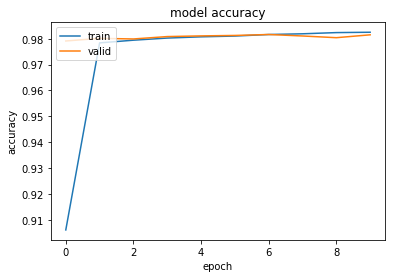

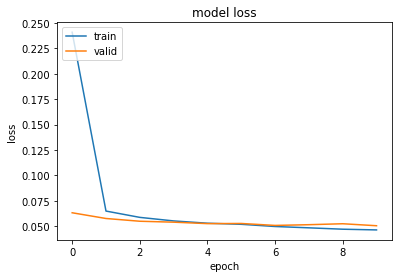

In [44]:
plot_loss_curve(model_wv_history)

In [53]:
model_wv.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 200)               0         
_________________________________________________________________
embedding_6 (Embedding)      (None, 200, 100)          7091000   
_________________________________________________________________
spatial_dropout1d_6 (Spatial (None, 200, 100)          0         
_________________________________________________________________
bidirectional_6 (Bidirection (None, 128)               84480     
_________________________________________________________________
dropout_5 (Dropout)          (None, 128)               0         
_________________________________________________________________
batch_normalization_5 (Batch (None, 128)               512       
_________________________________________________________________
dense_5 (Dense)              (None, 6)                 774       
Total para

In [52]:
# Apossible altrnative architecture

inp = Input(shape=(maxlen,), dtype='int32')
x = Embedding(num_words, EMBEDDING_DIM, mask_zero=False, weights=[embedding_matrix],
              input_length=maxlen, trainable=False)(inp)
x = Conv1D(128, 5, activation='relu')(x)
x = MaxPooling1D(5)(x)
x = Conv1D(128, 5, activation='relu')(x)
x = GlobalMaxPooling1D()(x)
x = Dense(6, activation="sigmoid")(x)
model_wv_cv = Model(inputs=inp, outputs=x)
model_wv_cv.compile(loss='binary_crossentropy',
                  optimizer=optimizers.Adam(lr=0.001, clipnorm=.25, beta_1=0.7, beta_2=0.99),
                  metrics=['accuracy'])
model_wv_cv_history = model_wv.fit([train_data], y, validation_split=0.1,
                 epochs=10, batch_size=256, shuffle=True)

Instructions for updating:
keep_dims is deprecated, use keepdims instead
Train on 86265 samples, validate on 9586 samples
Epoch 1/10
86265/86265 [==============================] - 290s - loss: 0.0456 - acc: 0.9828 - val_loss: 0.0520 - val_acc: 0.9812
Epoch 2/10
86265/86265 [==============================] - 279s - loss: 0.0446 - acc: 0.9831 - val_loss: 0.0512 - val_acc: 0.9817
Epoch 3/10
86265/86265 [==============================] - 283s - loss: 0.0445 - acc: 0.9830 - val_loss: 0.0501 - val_acc: 0.9821
Epoch 4/10
86265/86265 [==============================] - 286s - loss: 0.0433 - acc: 0.9836 - val_loss: 0.0503 - val_acc: 0.9819
Epoch 5/10
86265/86265 [==============================] - 284s - loss: 0.0429 - acc: 0.9836 - val_loss: 0.0507 - val_acc: 0.9817
Epoch 6/10
86265/86265 [==============================] - 309s - loss: 0.0423 - acc: 0.9837 - val_loss: 0.0509 - val_acc: 0.9818
Epoch 7/10
86265/86265 [==============================] - 294s - loss: 0.0420 - acc: 0.9837 - val_loss: 

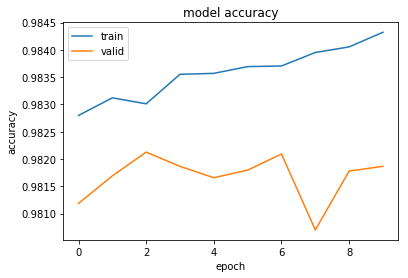

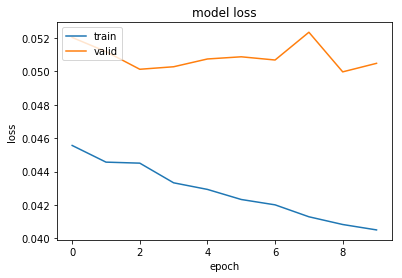

In [54]:
plot_loss_curve(model_wv_cv_history)

In [55]:
model_wv_cv.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        (None, 200)               0         
_________________________________________________________________
embedding_10 (Embedding)     (None, 200, 100)          7091000   
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 196, 128)          64128     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 39, 128)           0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 35, 128)           82048     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 128)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 6)                 774       
Total para